# Feature Selection Demo

[![Open In Colab <](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ShawnHymel/perfect-toast-machine/blob/master/feature_selection_demo_iris.ipynb)

Demonstrate feature selection using correlation and L1 regularization.

Original iris classification example from https://janakiev.com/blog/keras-iris/

## Step 1: Create Dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import tensorflow as tf

from sklearn.metrics import roc_curve, auc
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [ ]:
### Import Iris dataset

# Load dataset
iris = load_iris()
X = iris['data']
y = iris['target']
class_names = iris['target_names']
feature_names = iris['feature_names']

# One hot encoding
enc = OneHotEncoder()
Y = enc.fit_transform(y[:, np.newaxis]).toarray()

# Scale data to have mean 0 and variance 1 (standardization)
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.5, random_state=2)

In [ ]:
### View the data
print("X shape:", X_train.shape)
print("Y example:", Y_train.shape)
print("X example:")
print("\t", feature_names)
print("\t", X_train[0])
print("Y example:")
print("\t", class_names)
print("\t", Y_train[0])

X shape: (75, 4)
Y example: (75, 3)
X example:
	 ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
	 [ 0.06866179 -0.13197948  0.25122143  0.3957741 ]
Y example:
	 ['setosa' 'versicolor' 'virginica']
	 [0. 1. 0.]


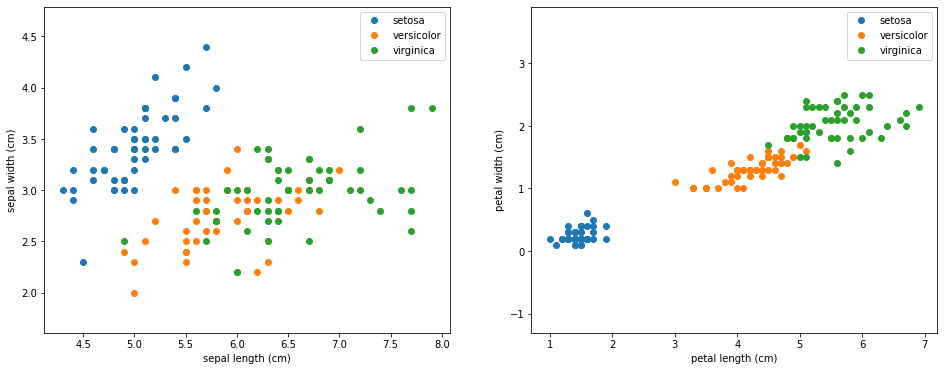

In [ ]:
### Plot the data

# Sepal width vs. height
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
for target, target_name in enumerate(class_names):
    X_plot = X[y == target]
    plt.plot(X_plot[:, 0], X_plot[:, 1], linestyle='none', marker='o', label=target_name)
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.axis('equal')
plt.legend();

# Petal width vs. height
plt.subplot(1, 2, 2)
for target, target_name in enumerate(class_names):
    X_plot = X[y == target]
    plt.plot(X_plot[:, 2], X_plot[:, 3], linestyle='none', marker='o', label=target_name)
plt.xlabel(feature_names[2])
plt.ylabel(feature_names[3])
plt.axis('equal')
plt.legend();

## Step 2: Examine Relationships Using Correlation


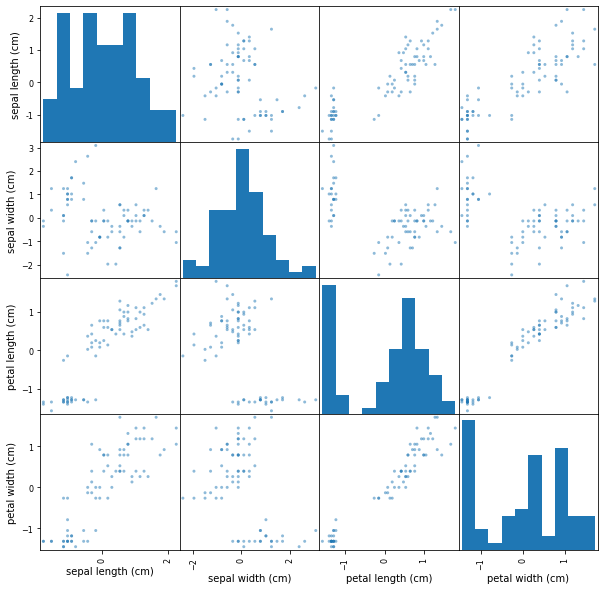

In [ ]:
### Plot scatter matrix to look for correlation (linear relationships)

# Convert NumPy array to Pandas DataFrame
X_train_df = pd.DataFrame(X_train, columns=feature_names)

# Create scatter matrix
sm = pd.plotting.scatter_matrix(X_train_df, figsize=(10, 10))

In [ ]:
### View raw Pearson correlation coefficients (PCCs)
pearson_corr = X_train_df.corr(method='pearson')
pearson_corr

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),1.000000,-0.247289,0.888887,0.845639
sepal width (cm),-0.247289,1.000000,-0.508204,-0.421748
petal length (cm),0.888887,-0.508204,1.000000,0.966589
petal width (cm),0.845639,-0.421748,0.966589,1.000000


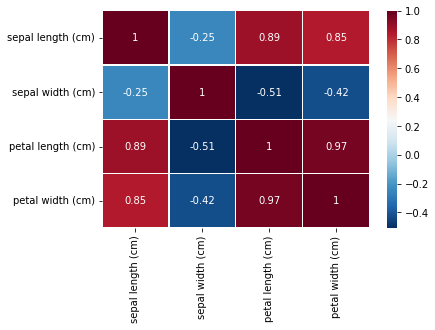

In [ ]:
### View heatmap of PCCs
sb.heatmap(pearson_corr, 
            xticklabels=pearson_corr.columns,
            yticklabels=pearson_corr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.2)

## Step 3: Perform Feature Importance Ranking with L1 Regularization

In [ ]:
### Plot training and validation accuracy and loss over time
def plot_history(history):

  # Extract accuracy and loss values (in list form) from the history
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Create a list of epoch numbers
  epochs = range(1, len(acc) + 1)

  # Plot training and validation loss values over time
  plt.figure(figsize=(5, 2))
  plt.plot(epochs, loss, color='blue', marker='.', label='Training loss')
  plt.plot(epochs, val_loss, color='orange', marker='.', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  # Plot training and validation accuracies over time
  plt.figure(figsize=(5, 2))
  plt.plot(epochs, acc, color='blue', marker='.', label='Training acc')
  plt.plot(epochs, val_acc, color='orange', marker='.', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.show()

In [ ]:
### Plot ROC curve
def plot_roc(model, X_test, Y_test):

  # Set up figure
  plt.figure(figsize=(3, 3))
  plt.plot([0, 1], [0, 1], 'k--')
  
  # Run inference
  Y_pred = model.predict(X_test)
  fpr, tpr, threshold = roc_curve(Y_test.ravel(), Y_pred.ravel())
      
  # Plot
  plt.plot(fpr, tpr, label='{}, AUC = {:.3f}'.format("model", auc(fpr, tpr)))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend()
  plt.show()

In [ ]:
### Generate feature importance rankings
def score_features(model):
  
  # Get weights (without the bias terms)
  weights = model.layers[0].get_weights()[0]

  # Take RMS of each set of weights (i.e. weights feeding into nodes for each feature)
  rms = np.sqrt(np.sum(np.square(weights), axis=1) / weights.shape[1])

  # Normalize the RMS scores
  norm_rms = rms / np.sum(rms)

  # Sort features by importance ranking (RMS)
  zip_features = zip(feature_names, rms, norm_rms)
  zip_features = sorted(zip_features, key = lambda x: x[1], reverse=True)

  # Print feature importance
  print("Feature importance (highest to lowest)")
  print("Feature name\t:\tRMS value\t:\tNormalized RMS")
  for name, rms, norm_rms in zip_features:
    print(name, "\t:\t", rms, "\t:\t", norm_rms)

In [ ]:
### Build model

# Settings
bias = True
kernel_reg = tf.keras.regularizers.L1(0.1)
bias_reg = tf.keras.regularizers.L1(0.1)
activity_reg = None

# Get dimensions
n_features = X_train.shape[1]
n_classes = Y_train.shape[1]

# First layer: adjust the regularizers for feature importance
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(4,
                                input_dim=n_features, 
                                use_bias=bias,
                                kernel_regularizer=kernel_reg,
                                bias_regularizer=bias_reg,
                                activity_regularizer=activity_reg,
                                activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))

# Second layer
model.add(tf.keras.layers.Dense(4,
                                activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))

# Output layer
model.add(tf.keras.layers.Dense(n_classes,
                                activation='softmax'))

# Configure the model's training settings
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

# Print out model summary and first layer weights
print(model.summary())
print("First layer weights:", model.layers[0].get_weights())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 4)                 20        
                                                                 
 dropout_2 (Dropout)         (None, 4)                 0         
                                                                 
 dense_4 (Dense)             (None, 4)                 20        
                                                                 
 dropout_3 (Dropout)         (None, 4)                 0         
                                                                 
 dense_5 (Dense)             (None, 3)                 15        
                                                                 
Total params: 55
Trainable params: 55
Non-trainable params: 0
_________________________________________________________________
None
First layer weights: [array([[ 0.33932537, -0.2946959

In [ ]:
### Train the model

# Settings
batch_size = 10
epochs = 300

# Train
history = model.fit(X_train, 
                    Y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(X_test, Y_test))

Epoch 1/300
8/8 [==============================] - 1s 31ms/step - loss: 1.6139 - acc: 0.4133 - val_loss: 1.5815 - val_acc: 0.4667
Epoch 2/300
8/8 [==============================] - 0s 6ms/step - loss: 1.6019 - acc: 0.4133 - val_loss: 1.5620 - val_acc: 0.5200
Epoch 3/300
8/8 [==============================] - 0s 6ms/step - loss: 1.5709 - acc: 0.4267 - val_loss: 1.5439 - val_acc: 0.3867
Epoch 4/300
8/8 [==============================] - 0s 7ms/step - loss: 1.5782 - acc: 0.3200 - val_loss: 1.5271 - val_acc: 0.4533
Epoch 5/300
8/8 [==============================] - 0s 10ms/step - loss: 1.5556 - acc: 0.4267 - val_loss: 1.5106 - val_acc: 0.4800
Epoch 6/300
8/8 [==============================] - 0s 7ms/step - loss: 1.5282 - acc: 0.3733 - val_loss: 1.4939 - val_acc: 0.4933
Epoch 7/300
8/8 [==============================] - 0s 7ms/step - loss: 1.5378 - acc: 0.3867 - val_loss: 1.4782 - val_acc: 0.5467
Epoch 8/300
8/8 [==============================] - 0s 7ms/step - loss: 1.5126 - acc: 0.4800 - v

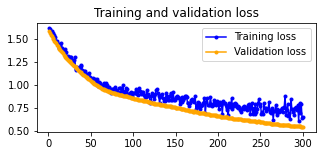

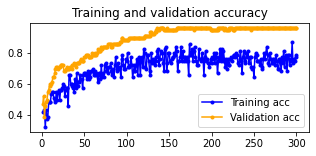

3/3 [==============================] - 0s 5ms/step


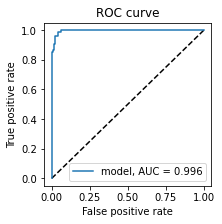

In [ ]:
# Plot history and ROC curve
plot_history(history)
plot_roc(model, X_test, Y_test)

In [ ]:
### View first layer weights
print(feature_names)
print("First layer weights:", model.layers[0].get_weights())

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
First layer weights: [array([[-1.3741260e-04,  6.3245972e-03,  2.3685658e-04,  8.7693927e-04],
       [ 1.2255265e-04,  1.1971014e-03,  1.3796416e-03, -1.4414731e-02],
       [-7.6711446e-04,  1.4452060e-02,  2.0522524e-03,  1.6232561e-01],
       [ 2.6172338e-04,  1.9819498e-02,  4.4506851e-01,  1.0856447e-02]],
      dtype=float32), array([-0.00024335, -0.00050443,  0.00028899,  0.2118778 ], dtype=float32)]


In [ ]:
### Score features
score_features(model)

Feature importance (highest to lowest)
Feature name	:	RMS value	:	Normalized RMS
petal width (cm) 	:	 0.22282097 	:	 0.7078785
petal length (cm) 	:	 0.0814912 	:	 0.25888887
sepal width (cm) 	:	 0.007265259 	:	 0.023080954
sepal length (cm) 	:	 0.0031954865 	:	 0.010151721


### Step 4: Drop Some Channels and Train Again

In [ ]:
### List features again
print(feature_names)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [ ]:
### Drop features of little importance

# To try:
# Drop [0,1] to line up with L1 importance ranking
# Drop [1,2,3] to show how sepal length doesn't help much
# Drop [0,1,2] to show how petal length can alone create a decent classifier
cols_to_drop = [0,1] 

# Drop columns to create new training/test features
X_train_dropped = np.delete(X_train, cols_to_drop, axis=1)
X_test_dropped = np.delete(X_test, cols_to_drop, axis=1)

# Update feature list
n_features_dropped = X_train_dropped.shape[1]

# Print shapes
print("New training set shape:", X_train_dropped.shape)
print("New test set shape:", X_test_dropped.shape)

New training set shape: (75, 2)
New test set shape: (75, 2)


In [ ]:
### Same model (different L1 values)

# Settings
bias = True
kernel_reg = tf.keras.regularizers.L1(0.001)
bias_reg = tf.keras.regularizers.L1(0.001)
activity_reg = None

# Get dimensions
n_features = X_train_dropped.shape[1]
n_classes = Y_train.shape[1]

# First layer: adjust the regularizers for feature importance
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(4,
                                input_dim=n_features, 
                                use_bias=bias,
                                kernel_regularizer=kernel_reg,
                                bias_regularizer=bias_reg,
                                activity_regularizer=activity_reg,
                                activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))

# Second layer
model.add(tf.keras.layers.Dense(4,
                                activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))

# Output layer
model.add(tf.keras.layers.Dense(n_classes,
                                activation='softmax'))

# Configure the model's training settings
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

# Print out model summary and first layer weights
print(model.summary())
print("First layer weights:", model.layers[0].get_weights())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 4)                 12        
                                                                 
 dropout_4 (Dropout)         (None, 4)                 0         
                                                                 
 dense_7 (Dense)             (None, 4)                 20        
                                                                 
 dropout_5 (Dropout)         (None, 4)                 0         
                                                                 
 dense_8 (Dense)             (None, 3)                 15        
                                                                 
Total params: 47
Trainable params: 47
Non-trainable params: 0
_________________________________________________________________
None
First layer weights: [array([[ 0.22763324,  0.3926763

In [ ]:
### Train the model

# Settings
batch_size = 10
epochs = 300

# Train
history = model.fit(X_train_dropped, 
                    Y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(X_test_dropped, Y_test))

Epoch 1/300
8/8 [==============================] - 1s 30ms/step - loss: 1.1755 - acc: 0.1600 - val_loss: 1.1665 - val_acc: 0.0133
Epoch 2/300
8/8 [==============================] - 0s 7ms/step - loss: 1.1612 - acc: 0.1467 - val_loss: 1.1469 - val_acc: 0.0267
Epoch 3/300
8/8 [==============================] - 0s 9ms/step - loss: 1.1955 - acc: 0.1200 - val_loss: 1.1295 - val_acc: 0.0267
Epoch 4/300
8/8 [==============================] - 0s 8ms/step - loss: 1.1356 - acc: 0.2267 - val_loss: 1.1138 - val_acc: 0.0400
Epoch 5/300
8/8 [==============================] - 0s 7ms/step - loss: 1.1653 - acc: 0.1600 - val_loss: 1.0988 - val_acc: 0.1600
Epoch 6/300
8/8 [==============================] - 0s 6ms/step - loss: 1.1182 - acc: 0.3200 - val_loss: 1.0851 - val_acc: 0.3733
Epoch 7/300
8/8 [==============================] - 0s 7ms/step - loss: 1.1192 - acc: 0.2667 - val_loss: 1.0731 - val_acc: 0.4800
Epoch 8/300
8/8 [==============================] - 0s 6ms/step - loss: 1.0924 - acc: 0.3867 - va

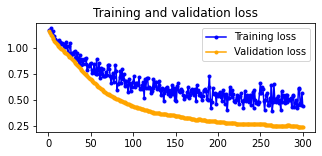

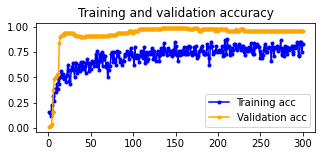

3/3 [==============================] - 0s 3ms/step


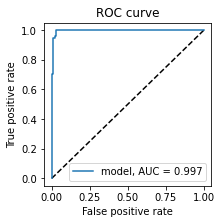

In [ ]:
# Plot history and ROC curve
plot_history(history)
plot_roc(model, X_test_dropped, Y_test)